# Training-aware quantization of Wav2Vec2 on GPU


This notebook provides code for training-aware quantization of the facebook/wav2vec2-base ASR model. We fine-tune the base model and then do training-aware quantization of a second instance of the model. Extensive evaluation and comparision between the base and the quantized models is performed.

First, let's install `datasets`,  `transformers` and `librosa`.

In [1]:
# %%capture
!pip install datasets==1.18.3
!pip install transformers==4.17.0
!pip install jiwer
!pip install librosa

In [2]:
device = 'cuda'

Next, we install `TensorRT` from source to use its tool `pytorch-quantization` for GPU quantization.

In [3]:
! git clone https://github.com/NVIDIA/TensorRT.git

In [4]:
! cd TensorRT/tools/pytorch-quantization && pip install .

In [ ]:
! pip install --upgrade tensorrt

## Prepare Data, Tokenizer, Feature Extractor

ASR models transcribe speech to text, which means that we both need a feature extractor that processes the speech signal to the model's input format, *e.g.* a feature vector, and a tokenizer that processes the model's output format to text.

In Transformers, the Wav2Vec2 model is thus accompanied by both a tokenizer, called [Wav2Vec2CTCTokenizer](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2ctctokenizer), and a feature extractor, called [Wav2Vec2FeatureExtractor](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2featureextractor).

Let's create the tokenizer responsible for decoding the model's predictions.

### Create Wav2Vec2CTCTokenizer

We load the dataset and taking a look at its structure.

In [6]:
from datasets import load_dataset, load_metric

timit = load_dataset("timit_asr")

Reusing dataset timit_asr (/home/kmb85/.cache/huggingface/datasets/timit_asr/clean/2.0.1/b11b576ddcccbcefa7c9f0c4e6c2a43756f3033adffe0fb686aa61043d0450ad)


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
timit

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 4620
    })
    test: Dataset({
        features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 1680
    })
})

In [8]:
timit = timit.remove_columns(["phonetic_detail", "word_detail", "dialect_region", "id", "sentence_type", "speaker_id"])

We normalize the text to only have lower case letters and append a word separator token at the end.

In [9]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    return batch

In [10]:
timit = timit.map(remove_special_characters)

Parameter 'function'=<function remove_special_characters at 0x7fa1eb446200> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

We write a mapping function that concatenates all transcriptions into one long transcription and then transforms the string into a set of chars.

In [11]:
def extract_all_chars(batch):
    all_text = " ".join(batch["text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

In [12]:
vocabs = timit.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=timit.column_names["train"])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Now, we create the union of all distinct letters in the training dataset and test dataset and convert the resulting list into an enumerated dictionary.

In [13]:
vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))

In [14]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}

We also add a padding token that corresponds to CTC's "*blank token*". The "blank token" is a core component of the CTC algorithm.

In [15]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [16]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)

Let's now save the vocabulary as a json file.

In [17]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In a final step, we use the json file to instantiate an object of the `Wav2Vec2CTCTokenizer` class.

In [18]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

### Create Wav2Vec2 Feature Extractor

In [19]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

In [20]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

Let's apply the data preparation function to all examples.

In [21]:
def prepare_dataset(batch):
    audio = batch["audio"]

    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [ ]:
timit = timit.map(prepare_dataset, remove_columns=timit.column_names["train"], num_proc=4)

In [23]:
max_input_length_in_sec = 4.0
timit["train"] = timit["train"].filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate, input_columns=["input_length"])

  0%|          | 0/5 [00:00<?, ?ba/s]

Now we are ready to start training!

### Set-up Trainer

Let's start by defining the data collator. The code for the data collator was copied from [this example](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81).

In [24]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [25]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Next, the evaluation metric is defined. As mentioned earlier, the
predominant metric in ASR is the word error rate (WER), hence we will use it in this notebook as well.

In [26]:
wer_metric = load_metric("wer")

The model will return a sequence of logit vectors:
$\mathbf{y}_1, \ldots, \mathbf{y}_m$ with $\mathbf{y}_1 = f_{\theta}(x_1, \ldots, x_n)[0]$ and $n >> m$.

In [27]:
import numpy as np

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)

    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [ ]:
from transformers import Wav2Vec2ForCTC, Trainer
from transformers import TrainingArguments

## Base Model Training

In [ ]:
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)
model = model.to(device)

In [27]:
model.freeze_feature_encoder()

In [40]:
training_args = TrainingArguments(
  output_dir="wav2vec2-librispeech-fine-tuned",
  group_by_length=True,
  per_device_train_batch_size=8,
  evaluation_strategy="steps",
  num_train_epochs=30,
  fp16=True,
  gradient_checkpointing=True,
  save_steps=500,
  eval_steps=500,
  logging_steps=500,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=1000,
  save_total_limit=2,
)

In [29]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=timit["train"],
    eval_dataset=timit["test"],
    tokenizer=processor.feature_extractor,
)

Using amp half precision backend


In [30]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
/home/kmb85/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3978
  Num Epochs = 30
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14940
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default 

Step,Training Loss,Validation Loss,Wer
500,3.622700,2.588284,1.000000
1000,1.007600,0.576139,0.535663
1500,0.443900,0.455326,0.450417
2000,0.291700,0.422361,0.418648
2500,0.229200,0.551138,0.472538
3000,0.190300,0.397420,0.389980
3500,0.159900,0.428962,0.378472
4000,0.144600,0.429979,0.377576
4500,0.125900,0.442152,0.365585
5000,0.111500,0.429308,0.360141


The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1680
  Batch size = 8
Saving model checkpoint to wav2vec2-librispeech-finetuned/checkpoint-500
Configuration saved in wav2vec2-librispeech-finetuned/checkpoint-500/config.json
Model weights saved in wav2vec2-librispeech-finetuned/checkpoint-500/pytorch_model.bin
Feature extractor saved in wav2vec2-librispeech-finetuned/checkpoint-500/preprocessor_config.json
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_r

TrainOutput(global_step=14940, training_loss=0.2459322794055045, metrics={'train_runtime': 4172.7017, 'train_samples_per_second': 28.6, 'train_steps_per_second': 3.58, 'total_flos': 3.0766610595969556e+18, 'train_loss': 0.2459322794055045, 'epoch': 30.0})

In [33]:
torch.onnx.export(model,
             torch.tensor(timit["train"][:1]["input_values"]).cuda(),
             "wav2vec2_base.onnx",
             export_params=True,
             opset_version=11,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

## Training-Aware Quantization

In [29]:
import pytorch_quantization
from pytorch_quantization import nn as quant_nn
from pytorch_quantization import quant_modules
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization import calib

In [30]:
model_quantized = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)

/home/kmb85/.local/lib/python3.10/site-packages/transformers/configuration_utils.py:356: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForCTC: ['project_hid.bias', 'quantizer.codevectors', 'project_q.bias', 'quantizer.weight_proj.bias', 'project_q.weight', 'quantizer.weight_proj.weight', 'project_hid.weight']
- This IS expected if you ar

In [31]:
quant_desc_input = QuantDescriptor(calib_method='max', num_bits=4, fake_quant=True)
quant_nn.QuantConv1d.set_default_quant_desc_input(quant_desc_input)
quant_nn.QuantLinear.set_default_quant_desc_input(quant_desc_input)

In [ ]:
quant_modules.initialize()
model_full_quantized = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base",
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)

In [33]:
model_quantized = model_quantized.to(device)
model_full_quantized = model_full_quantized.to(device)

First, calibrate the quantized model

In [34]:
model_full_quantized.wav2vec2.encoder.layers[0].feed_forward.intermediate_dense._weight_quantizer.enable_calib()
model_full_quantized.wav2vec2.encoder.layers[0].feed_forward.intermediate_dense._weight_quantizer.disable_quant()

model_full_quantized.wav2vec2.encoder.layers[0].feed_forward.output_dense._weight_quantizer.enable_calib()
model_full_quantized.wav2vec2.encoder.layers[0].feed_forward.output_dense._weight_quantizer.disable_quant()

In [35]:
with torch.no_grad():
    for i in range(2000):
            _ = model_full_quantized(torch.tensor(timit["train"][i:i+1]["input_values"], device="cuda"))

In [36]:
# Finalize calibration

model_full_quantized.wav2vec2.encoder.layers[0].feed_forward.intermediate_dense._weight_quantizer.load_calib_amax()
model_full_quantized.wav2vec2.encoder.layers[0].feed_forward.intermediate_dense._weight_quantizer.disable_calib()
model_full_quantized.wav2vec2.encoder.layers[0].feed_forward.intermediate_dense._weight_quantizer.enable_quant()

model_full_quantized.wav2vec2.encoder.layers[0].feed_forward.output_dense._weight_quantizer.load_calib_amax()
model_full_quantized.wav2vec2.encoder.layers[0].feed_forward.output_dense._weight_quantizer.disable_calib()
model_full_quantized.wav2vec2.encoder.layers[0].feed_forward.output_dense._weight_quantizer.enable_quant()

model_full_quantized.cuda()

W1214 13:35:39.393166 140335054594048 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([3072, 1]).
W1214 13:35:39.394813 140335054594048 tensor_quantizer.py:239] Call .cuda() if running on GPU after loading calibrated amax.
W1214 13:35:39.395303 140335054594048 tensor_quantizer.py:174] Disable MaxCalibrator
W1214 13:35:39.395805 140335054594048 tensor_quantizer.py:238] Load calibrated amax, shape=torch.Size([768, 1]).
W1214 13:35:39.396168 140335054594048 tensor_quantizer.py:174] Disable MaxCalibrator


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): QuantConv1d(
            1, 512, kernel_size=(10,), stride=(5,), bias=False
            (_input_quantizer): TensorQuantizer(4bit fake per-tensor amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
            (_weight_quantizer): TensorQuantizer(8bit fake axis=0 amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
          )
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): QuantConv1d(
            512, 512, kernel_size=(3,), stride=(2,), bias=False
            (_input_quantizer): TensorQuantizer(4bit fake per-tensor amax=dynamic calibrator=MaxCalibrator scale=1.0 quant)
            (_weight_quantizer): TensorQuantizer(8bit fake axis=0 amax=dynamic calibrator=MaxC

In our final quantized model, we only keep the quantized `feed_forward` network.

In [37]:
model_quantized.wav2vec2.encoder.layers[0].feed_forward.output_dense = model_full_quantized.wav2vec2.encoder.layers[0].feed_forward.output_dense
model_quantized.wav2vec2.encoder.layers[0].feed_forward.intermediate_dense = model_full_quantized.wav2vec2.encoder.layers[0].feed_forward.intermediate_dense

In [38]:
model_quantized.freeze_feature_encoder()

In [41]:
trainer_quant = Trainer(
    model=model_quantized,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=timit["train"],
    eval_dataset=timit["test"],
    tokenizer=processor.feature_extractor,
)

Using amp half precision backend


In [42]:
trainer_quant.train()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
/home/kmb85/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3978
  Num Epochs = 30
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14940
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default 

Step,Training Loss,Validation Loss,Wer
500,3.587600,2.696902,1.000000
1000,1.092900,0.578868,0.552615
1500,0.489700,0.452044,0.468817
2000,0.332600,0.423092,0.438633
2500,0.251200,0.411929,0.413755
3000,0.205200,0.441093,0.399628
3500,0.171300,0.461883,0.397354
4000,0.157500,0.458877,0.389911
4500,0.135700,0.468411,0.388877
5000,0.115300,0.473833,0.382951


The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1680
  Batch size = 8
Saving model checkpoint to wav2vec2-librispeech-fine-tuned/checkpoint-500
Configuration saved in wav2vec2-librispeech-fine-tuned/checkpoint-500/config.json
Model weights saved in wav2vec2-librispeech-fine-tuned/checkpoint-500/pytorch_model.bin
Feature extractor saved in wav2vec2-librispeech-fine-tuned/checkpoint-500/preprocessor_config.json
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use u

TrainOutput(global_step=14940, training_loss=0.25453308219092596, metrics={'train_runtime': 4322.0408, 'train_samples_per_second': 27.612, 'train_steps_per_second': 3.457, 'total_flos': 3.0766610595969556e+18, 'train_loss': 0.25453308219092596, 'epoch': 30.0})

The `pytorch-quantization` only provides `fake` quantization. The quantization is simulatedon the model's weights and activations without actually converting them to lower-bit representations. To get the quantized model, we need to export the model to ONNX. Fake quantization will be broken into a pair of QuantizeLinear/DequantizeLinear ONNX operations. TensorRT will take the generated ONNX graph, and execute it in int8 in the most optimized way to its capability.

In [43]:
torch.onnx.export(model_quantized,
             torch.tensor(timit["train"][:1]["input_values"]).cuda(),
             "wav2vec2_qat.onnx",
             export_params=True,
             opset_version=11,
             do_constant_folding=True,
             input_names = ['modelInput'],
             output_names = ['modelOutput'],
             dynamic_axes={'modelInput' : {0 : 'batch_size', 1: 'batch_size'},
             'modelOutput' : {0 : 'batch_size'}}
)

/home/kmb85/.local/lib/python3.10/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:637: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
/home/kmb85/.local/lib/python3.10/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:674: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
/home/kmb85/.local/lib/python3.10/site-packages/pytorch_quantization/tensor_quant.py:257: TracerWarning: Converting a t

### Base vs Quantized Model Inference Time

In this section, we compare the inference time of the base model and the quantized model on the test data. Furthermore, we evalute the perfomance of the base and the quantized models using the word error rate (WER) metric.

**Inference**

In [ ]:
! pip install onnxruntime-gpu

In [44]:
import onnxruntime as ort
import tensorrt
ort.get_device()

'GPU'

In [45]:
# Load onnx models
ort_sess_quant = ort.InferenceSession('wav2vec2_qat.onnx', providers=['TensorrtExecutionProvider'])
ort_sess_base = ort.InferenceSession('wav2vec2_base.onnx')

2023-12-14 15:23:44.775161614 [W:onnxruntime:Default, tensorrt_execution_provider.h:77 log] [2023-12-14 15:23:44 WARNING] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
2023-12-14 15:23:51.568104077 [W:onnxruntime:Default, tensorrt_execution_provider.h:77 log] [2023-12-14 15:23:51 WARNING] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.


In [50]:
import time
import numpy
num_samples = 50

def compute_inference_time(ort_sess, num_samples):
    model_time = 0
    with torch.no_grad():
        for single_batch in timit["test"].select(range(num_samples)):
            input_values = torch.tensor(single_batch["input_values"], device="cpu").unsqueeze(0)
            input_values = input_values.clone().detach().numpy().astype(numpy.float32)
            starttime = time.time()
            ort_sess.run(['modelOutput'], {'modelInput': input_values})
            model_time += time.time() - starttime
    return round(model_time/num_samples, 2)

In [72]:
base_model_time = compute_inference_time(ort_sess_base, num_samples)
print(f'Base Model inference time {base_model_time} seconds')

Base Model inference time 0.07 seconds


In [56]:
quantized_model_time = compute_inference_time(ort_sess_quant, num_samples)

In [57]:
print(f'Quantized Model inference time {quantized_model_time} seconds')

Quantized Model inference time 0.01 seconds


**Inference Time Visualisation of Results**

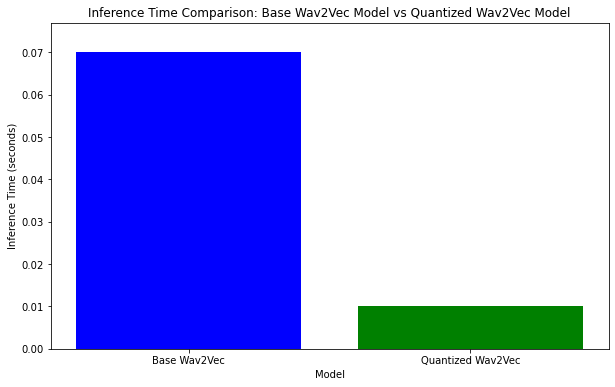

In [59]:
import matplotlib.pyplot as plt

models = ['Base Wav2Vec', 'Quantized Wav2Vec']
inference_times = [base_model_time, quantized_model_time]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time Comparison: Base Wav2Vec Model vs Quantized Wav2Vec Model')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()

We calculate how many times the quantized model is faster than the base model

In [74]:
speedup_ratio = base_model_time / quantized_model_time
print(f'Quantized fine-tuned wav2vec2 is {round(speedup_ratio)} times faster than base fine-tuned wav2vec2')

Quantized fine-tuned wav2vec2 is 7 times faster than base fine-tuned wav2vec2


**Evaluating WER metric**

In [60]:
def map_model_to_wer_result(ort_sess, single_batch):
    input_values = torch.tensor(single_batch["input_values"], device="cpu").unsqueeze(0)
    input_values = input_values.clone().detach().numpy().astype(numpy.float32)
    with torch.no_grad():
        outputs = ort_sess.run(['modelOutput'], {'modelInput': input_values})
        logits = torch.tensor(outputs[0])

    pred_ids = torch.argmax(logits, dim=-1)
    return processor.batch_decode(pred_ids)[0], processor.decode(single_batch["labels"], group_tokens=False)

In [61]:
num_samples = 500

In [77]:
results_base = {
    "pred_str":[],
    "text":[]
}

for single_batch in timit["test"].select(range(num_samples)):
    batch_pred_str, batch_text = map_model_to_wer_result(ort_sess_base, single_batch)
    results_base["pred_str"].append(batch_pred_str)
    results_base["text"].append(batch_text)

base_wer_result = wer_metric.compute(predictions=results_base["pred_str"], references=results_base["text"])

In [78]:
print("Base Model WER: {:.3f}".format(base_wer_result))

Base Model WER: 0.215


In [64]:
results_quantized = {
    "pred_str":[],
    "text":[]
}

for single_batch in timit["test"].select(range(num_samples)):
    batch_pred_str, batch_text = map_model_to_wer_result(ort_sess_quant, single_batch)
    results_quantized["pred_str"].append(batch_pred_str)
    results_quantized["text"].append(batch_text)


quant_wer_result = wer_metric.compute(predictions=results_quantized["pred_str"], references=results_quantized["text"])

In [65]:
print("Quantized Model WER: {:.3f}".format(quant_wer_result))

Quantized Model WER: 0.249


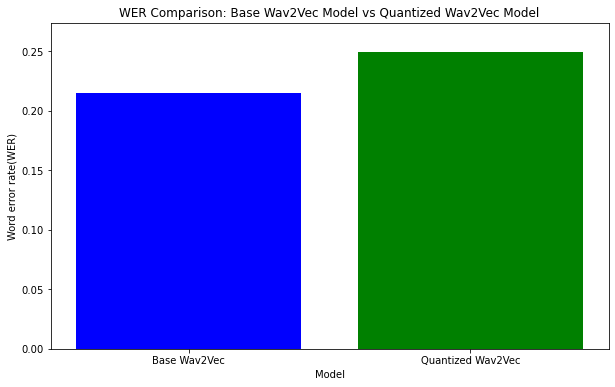

In [67]:
import matplotlib.pyplot as plt

models = ['Base Wav2Vec', 'Quantized Wav2Vec']
inference_times = [base_wer_result, quant_wer_result]

plt.figure(figsize=(10, 6))
plt.bar(models, inference_times, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Word error rate(WER)')
plt.title('WER Comparison: Base Wav2Vec Model vs Quantized Wav2Vec Model')
plt.ylim(0, max(inference_times) * 1.1)
plt.show()

In [68]:
percentage_diff = ((quant_wer_result - 0.215) / quant_wer_result) * 100
print(f'WER difference between the quantized model is and the base model is {round(percentage_diff, 2)}%')

WER difference between the quantized model is and the base model is 13.76%
